# Отток клиентов

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Вам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 

Постройте модель с предельно большим значением *F1*-меры. Чтобы сдать проект успешно, нужно довести метрику до 0.59. Проверьте *F1*-меру на тестовой выборке самостоятельно.

Дополнительно измеряйте *AUC-ROC*, сравнивайте её значение с *F1*-мерой.

Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

## Подготовка данных

In [1]:
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.utils import shuffle
from sklearn.metrics import precision_score, recall_score, make_scorer, roc_curve, f1_score, roc_auc_score, classification_report
import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings("ignore")

data = pd.read_csv('/datasets/Churn.csv')

In [2]:
data.isna().mean()

RowNumber          0.0000
CustomerId         0.0000
Surname            0.0000
CreditScore        0.0000
Geography          0.0000
Gender             0.0000
Age                0.0000
Tenure             0.0909
Balance            0.0000
NumOfProducts      0.0000
HasCrCard          0.0000
IsActiveMember     0.0000
EstimatedSalary    0.0000
Exited             0.0000
dtype: float64

In [3]:
data.head(10)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0
5,6,15574012,Chu,645,Spain,Male,44,8.0,113755.78,2,1,0,149756.71,1
6,7,15592531,Bartlett,822,France,Male,50,7.0,0.00,2,1,1,10062.80,0
7,8,15656148,Obinna,376,Germany,Female,29,4.0,115046.74,4,1,0,119346.88,1
8,9,15792365,He,501,France,Male,44,4.0,142051.07,2,0,1,74940.50,0
9,10,15592389,H?,684,France,Male,27,2.0,134603.88,1,1,1,71725.73,0


In [4]:
data.columns = 'row_number', 'customer_id', 'surname','credit_score', 'geography', 'gender', 'age', 'tenure', 'balance', 'num_of_products', 'has_cr_card', 'is_active_member', 'estimated_salary', 'exited'

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   row_number        10000 non-null  int64  
 1   customer_id       10000 non-null  int64  
 2   surname           10000 non-null  object 
 3   credit_score      10000 non-null  int64  
 4   geography         10000 non-null  object 
 5   gender            10000 non-null  object 
 6   age               10000 non-null  int64  
 7   tenure            9091 non-null   float64
 8   balance           10000 non-null  float64
 9   num_of_products   10000 non-null  int64  
 10  has_cr_card       10000 non-null  int64  
 11  is_active_member  10000 non-null  int64  
 12  estimated_salary  10000 non-null  float64
 13  exited            10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


In [6]:
data['tenure'] = data['tenure'].fillna(data['tenure'].median())

In [7]:
data_1 = data.drop(['row_number', 'customer_id', 'surname'], axis=1)

In [8]:
data_ohe = pd.get_dummies(data_1, drop_first=True)
data_ohe

,credit_score,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited,geography_Germany,geography_Spain,gender_Male
0,619,42,2.0,0.00,1,1,1,101348.88,1,0,0,0
1,608,41,1.0,83807.86,1,0,1,112542.58,0,0,1,0
2,502,42,8.0,159660.80,3,1,0,113931.57,1,0,0,0
3,699,39,1.0,0.00,2,0,0,93826.63,0,0,0,0
4,850,43,2.0,125510.82,1,1,1,79084.10,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
9995,771,39,5.0,0.00,2,1,0,96270.64,0,0,0,1
9996,516,35,10.0,57369.61,1,1,1,101699.77,0,0,0,1
9997,709,36,7.0,0.00,1,0,1,42085.58,1,0,0,0
9998,772,42,3.0,75075.31,2,1,0,92888.52,1,1,0,1


Загруженные данные имеют пропуски в столбце tenure (продолжительность нахождения в клиентах банка). Данные в текстовых столбцах представлены в формате object, данные в числовых столбцах предствлены в форматах int и float. Отсутствующие значения в столбце tenure заменили медианным значением данного столбца. Уберали столбцы row_number, customer_id, surname. Созданы мнимые признаки для столбцов geography, gender.

## Исследование задачи

In [9]:
data_ohe['exited'].value_counts(normalize=True)

0    0.7963
1    0.2037
Name: exited, dtype: float64

данные с классами 0 (действующий) и 1 (ушедший) соотносятся 80 % и 20 % соответственно. Без дополнительной обработки (добавления к меньшему классу доп.значений, удаления из данных части значений доминирующего класса) модель будет выдавать много ответов с классом 0 (действующий), что будет ее незначительно отличать от предсказаний на константной (полностью заполненной значениями класса 0) модели.

In [10]:
features = data_ohe.drop(['exited'], axis=1)
target = data_ohe['exited']
features_train, features_valid, target_train, target_valid = train_test_split(features, 
                                            target, test_size = 0.2, random_state=12345)
features_train, features_test, target_train, target_test = train_test_split(features_train, 
                                     target_train, test_size = 0.25, random_state=12345)

разделили выборку на обучающую, валидационную и тестовую

получим оптимальную модель случайного леса

In [11]:
model = RandomForestClassifier(random_state = 12345)
params = {
    'n_estimators':range(10,100,10),
    'max_depth': range(1,17,2),
    'min_samples_split': range(1, 11, 2),
    'min_samples_leaf': range(1, 11, 2)}
scores = {
    'precision_score': make_scorer(precision_score),
    'recall_score': make_scorer(recall_score),
    'f1_score': make_scorer(f1_score)
}
grid_model_rf_base = GridSearchCV(model, params, scoring = scores, refit = 'f1_score', cv=3, n_jobs=-1)
grid_model_rf_base.fit(features_train, target_train)

GridSearchCV(cv=3, estimator=RandomForestClassifier(random_state=12345),
             n_jobs=-1,
             param_grid={'max_depth': range(1, 17, 2),
                         'min_samples_leaf': range(1, 11, 2),
                         'min_samples_split': range(1, 11, 2),
                         'n_estimators': range(10, 100, 10)},
             refit='f1_score',
             scoring={'f1_score': make_scorer(f1_score),
                      'precision_score': make_scorer(precision_score),
                      'recall_score': make_scorer(recall_score)})

In [12]:
rf_param = grid_model_rf_base.best_params_
grid_model_rf_base.best_params_

{'max_depth': 13,
 'min_samples_leaf': 1,
 'min_samples_split': 5,
 'n_estimators': 50}

In [13]:
max_depth_rf = rf_param['max_depth']
min_samples_leaf_rf = rf_param['min_samples_leaf']
min_samples_split_rf = rf_param['min_samples_split']
n_estimators_rf = rf_param['n_estimators']

In [14]:
print(classification_report(target_test, grid_model_rf_base.predict(features_test), 
                            target_names=['is_not_exited', 'exited']))

               precision    recall  f1-score   support

is_not_exited       0.88      0.97      0.92      1609
       exited       0.77      0.43      0.56       391

     accuracy                           0.86      2000
    macro avg       0.82      0.70      0.74      2000
 weighted avg       0.85      0.86      0.85      2000



In [15]:
predicted_test_rf = grid_model_rf_base.predict(features_test)
probabilities_test_rf = grid_model_rf_base.predict_proba(features_test)
probabilities_one_test_rf = probabilities_test_rf[:, 1]

print(roc_auc_score (target_test, probabilities_one_test_rf))

0.8482067780499397


получим оптимальную модель дерева принятия решений

In [16]:
model = DecisionTreeClassifier(random_state = 12345)
params = {'max_depth': range(1,17,2),
    'min_samples_split': range(1, 11, 2),
    'min_samples_leaf': range(1, 11, 2)}

scores = {
    'precision_score': make_scorer(precision_score),
    'recall_score': make_scorer(recall_score),
    'f1_score': make_scorer(f1_score)}
    
grid_model_dt = GridSearchCV(model, params, scoring = scores, refit = 'f1_score', cv=3, n_jobs=-1)
grid_model_dt.fit(features_train, target_train)

GridSearchCV(cv=3, estimator=DecisionTreeClassifier(random_state=12345),
             n_jobs=-1,
             param_grid={'max_depth': range(1, 17, 2),
                         'min_samples_leaf': range(1, 11, 2),
                         'min_samples_split': range(1, 11, 2)},
             refit='f1_score',
             scoring={'f1_score': make_scorer(f1_score),
                      'precision_score': make_scorer(precision_score),
                      'recall_score': make_scorer(recall_score)})

In [17]:
grid_model_dt.best_params_

{'max_depth': 11, 'min_samples_leaf': 7, 'min_samples_split': 3}

In [18]:
print(classification_report(target_test, grid_model_dt.predict(features_test), 
                      target_names=['is_not_exited', 'exited']))

               precision    recall  f1-score   support

is_not_exited       0.88      0.93      0.91      1609
       exited       0.64      0.47      0.54       391

     accuracy                           0.84      2000
    macro avg       0.76      0.70      0.72      2000
 weighted avg       0.83      0.84      0.83      2000



In [19]:
probabilities_test = grid_model_dt.predict_proba(features_test)
probabilities_one_test_dt = probabilities_test[:, 1]
print(roc_auc_score (target_test, probabilities_one_test_dt))

0.7729626668404547


In [20]:
grid_model=LogisticRegression(solver='newton-cg', max_iter = 100)
grid_model.fit(features_train, target_train)

LogisticRegression(solver='newton-cg')

In [22]:
print(classification_report(target_test, grid_model.predict(features_test), 
                      target_names=['is_not_exited', 'exited']))

               precision    recall  f1-score   support

is_not_exited       0.83      0.96      0.89      1609
       exited       0.58      0.20      0.30       391

     accuracy                           0.81      2000
    macro avg       0.70      0.58      0.60      2000
 weighted avg       0.78      0.81      0.78      2000



In [23]:
probabilities_test = grid_model.predict_proba(features_test)
probabilities_one_test_lr = probabilities_test[:, 1]
print(roc_auc_score (target_test, probabilities_one_test_lr))

0.7680963378947385


In [29]:
best_f1_score = 0
best_depth = 0
best_est = 0
for est in range (20, 100, 10):
    for depth in range(1, 16, 1):
        model=RandomForestClassifier(n_estimators = est, max_depth=depth, random_state = 12345)
        model.fit(features_train, target_train)
        predicted_valid = model.predict(features_valid)
        model_f1_score = f1_score(target_valid, predicted_valid)
        if model_f1_score > best_f1_score:
            best_f1_score = model_f1_score
            best_depth = depth
            best_est = est
print(best_f1_score, best_depth, best_est)

0.5806451612903226 15 80


In [30]:
print(classification_report(target_valid, model.predict(features_valid), 
                      target_names=['is_not_exited', 'exited']))

               precision    recall  f1-score   support

is_not_exited       0.87      0.97      0.91      1573
       exited       0.78      0.46      0.58       427

     accuracy                           0.86      2000
    macro avg       0.83      0.71      0.75      2000
 weighted avg       0.85      0.86      0.84      2000



In [33]:
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

print(roc_auc_score (target_valid, probabilities_one_valid))

0.8587545092761188


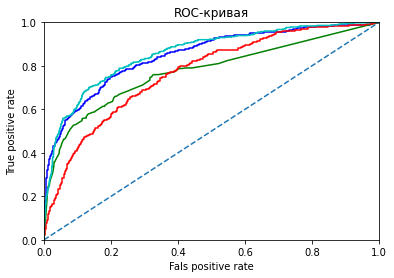

In [34]:
fpr_rf, tpr_rf, thresholds_rf = roc_curve(target_test, probabilities_one_test_rf)
fpr_dt, tpr_dt, thresholds_dt = roc_curve(target_test, probabilities_one_test_dt)
fpr_lr, tpr_lr, thresholds_lr = roc_curve(target_test, probabilities_one_test_lr)
fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)


plt.figure()

plt.plot([0, 1], [0, 1], linestyle = '--')
plt.plot(fpr_rf, tpr_rf, color = 'b')
plt.plot(fpr_dt, tpr_dt, color = 'g')
plt.plot(fpr_lr, tpr_lr, color = 'r')
plt.plot(fpr, tpr, color = 'c')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('Fals positive rate')
plt.ylabel('True positive rate')
plt.title('ROC-кривая')

plt.show()

Мы протестировали модели случайного леса, дерева принятия решения и логистической регрессии на имеющихся несбалансированных данных. Показатель метрики f1 на тестовой выборке (валидационную выборку не используем в связи с применением метода GridSearchCV) для ушедших клиентов во всех случаях меньше целелевого показателя 0,59. Для улучшения данного показателя применим методы балансировки обучающей выборки (взвешивание классов, уменьшение превалирующего класса, увеличение класса, находящегося в меньшинстве, сдвиг порога классификации). Метрики получаемые на модели случайного леса выше остальных моделей в связи с эти будем использовать эту модель для тестирования методов борьбы с дисбалансом выборки.

## Борьба с дисбалансом

### Взвешивание классов

In [35]:
model = RandomForestClassifier(class_weight='balanced', random_state = 12345)
params = {
    'n_estimators':range(10,100,10),
    'max_depth': range(1,17,2),
    'min_samples_split': range(1, 11, 2),
    'min_samples_leaf': range(1, 11, 2)}
scores = {
    'precision_score': make_scorer(precision_score),
    'recall_score': make_scorer(recall_score),
    'f1_score': make_scorer(f1_score)
}
model_rf = GridSearchCV(model, params, scoring = scores, refit = 'f1_score', cv=3, n_jobs=-1)
model_rf.fit(features_train, target_train)

GridSearchCV(cv=3,
             estimator=RandomForestClassifier(class_weight='balanced',
                                              random_state=12345),
             n_jobs=-1,
             param_grid={'max_depth': range(1, 17, 2),
                         'min_samples_leaf': range(1, 11, 2),
                         'min_samples_split': range(1, 11, 2),
                         'n_estimators': range(10, 100, 10)},
             refit='f1_score',
             scoring={'f1_score': make_scorer(f1_score),
                      'precision_score': make_scorer(precision_score),
                      'recall_score': make_scorer(recall_score)})

In [36]:
model_rf.best_params_

{'max_depth': 11,
 'min_samples_leaf': 3,
 'min_samples_split': 9,
 'n_estimators': 90}

### Увеличение выборки

In [39]:
repeat = 4
features_zeros = features_train[target == 0]
features_ones = features_train[target == 1]
target_zeros = target_train[target == 0]
target_ones = target_train[target == 1]
upsamping_features = pd.concat([features_zeros]+[features_ones]*repeat)
upsamping_target = pd.concat([target_zeros]+[target_ones]*repeat)

upsamping_features_train, upsamping_target_train = shuffle(upsamping_features, upsamping_target, 
                                                random_state = 12345)

### Уменьшение выборки

In [43]:
fraction = 0.25
features_zeros = features_train[target == 0]
features_ones = features_train[target == 1]
target_zeros = target_train[target == 0]
target_ones = target_train[target == 1]
downsampled_features = pd.concat([features_zeros.sample(frac=fraction, random_state=12345)]
                                 +[features_ones])
downsampled_target = pd.concat([target_zeros.sample(frac=fraction, random_state = 12345)]+
                               [target_ones])

downsampled_features_train, downsampled_target_train = shuffle(downsampled_features, 
                                                            downsampled_target,random_state = 12345)

### Изменение порога классификации

In [47]:
predicted_test_1 = predicted_test_rf
probabilities_one_test_adj_thr = probabilities_one_test_rf
model_f1_score = f1_score(target_test, predicted_test_1)
model_f1_score

0.5555555555555555

In [48]:
fpr, tpr, thresholds_1 = roc_curve(target_test, probabilities_one_test_adj_thr)

J = tpr - fpr
ix = np.argmax(J)
best_thresh = thresholds_1[ix]
print('Best Threshold=%f' % (best_thresh))
print(best_thresh)

Best Threshold=0.229493
0.22949260535739582


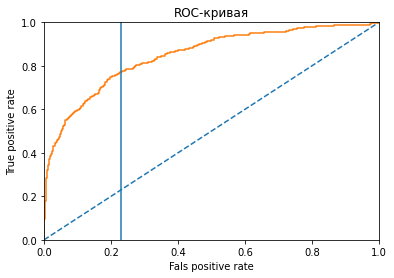

In [49]:
plt.figure()

plt.plot([0, 1], [0, 1], linestyle = '--')
plt.plot(fpr, tpr)
plt.axvline(best_thresh)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('Fals positive rate')
plt.ylabel('True positive rate')
plt.title('ROC-кривая')

plt.show()

In [50]:
def adjusted_classes (probabilities_one_test_1, t):
    return[1 if y >= t else 0 for y in probabilities_one_test_1]

predict_test_adjust = adjusted_classes(probabilities_one_test_adj_thr, best_thresh)

print('f1 метрика {:.2f}'. format(f1_score(target_test, predict_test_adjust)))
print('roc_auc_метрика {:.3f}'.format(roc_auc_score (target_test, probabilities_one_test_adj_thr)))

f1 метрика 0.59
roc_auc_метрика 0.848


Применены методы борьбы с несбалансированностью выборки (взвешивание классов, увеличение выборки, уменьшение выборки, изменение порога классификации). Метод изменения классификационного порога показал следующие метрики f1 - 0,59, roc_auc - 0,848. Метрики остальных методов борьбы с дисбалансом рассмотрим в следующем разделе на тестовой выборке.

## Тестирование модели

### Взвещенные данные

In [52]:
print(classification_report(target_test, model_rf.predict(features_test), 
                            target_names=['is_not_exited', 'exited']))

               precision    recall  f1-score   support

is_not_exited       0.91      0.89      0.90      1609
       exited       0.58      0.62      0.60       391

     accuracy                           0.84      2000
    macro avg       0.74      0.76      0.75      2000
 weighted avg       0.84      0.84      0.84      2000



In [53]:
probabilities_test = model_rf.predict_proba(features_test)
probabilities_one_test_nd = probabilities_test[:, 1]

print(roc_auc_score (target_test, probabilities_one_test_nd))

0.8522394014486925


### Увеличенная выборка

In [54]:
model = RandomForestClassifier(random_state = 12345)
params = {
    'n_estimators':range(10,100,10),
    'max_depth': range(1,17,2),
    'min_samples_split': range(1, 11, 2),
    'min_samples_leaf': range(1, 11, 2)}
scores = {
    'precision_score': make_scorer(precision_score),
    'recall_score': make_scorer(recall_score),
    'f1_score': make_scorer(f1_score)
}
model_rf1 = GridSearchCV(model, params, scoring = scores, refit = 'f1_score', cv=2, n_jobs=-1)
model_rf1.fit(upsamping_features_train, upsamping_target_train)

GridSearchCV(cv=2, estimator=RandomForestClassifier(random_state=12345),
             n_jobs=-1,
             param_grid={'max_depth': range(1, 17, 2),
                         'min_samples_leaf': range(1, 11, 2),
                         'min_samples_split': range(1, 11, 2),
                         'n_estimators': range(10, 100, 10)},
             refit='f1_score',
             scoring={'f1_score': make_scorer(f1_score),
                      'precision_score': make_scorer(precision_score),
                      'recall_score': make_scorer(recall_score)})

In [55]:
print(classification_report(target_test, model_rf1.predict(features_test), 
                            target_names=['is_not_exited', 'exited']))

               precision    recall  f1-score   support

is_not_exited       0.90      0.91      0.90      1609
       exited       0.61      0.57      0.59       391

     accuracy                           0.84      2000
    macro avg       0.75      0.74      0.75      2000
 weighted avg       0.84      0.84      0.84      2000



In [56]:
probabilities_test = model_rf1.predict_proba(features_test)
probabilities_one_test_up = probabilities_test[:, 1]

print(roc_auc_score (target_test, probabilities_one_test_up))

0.8454704117980858


In [57]:
model_rf1.best_params_

{'max_depth': 15,
 'min_samples_leaf': 1,
 'min_samples_split': 3,
 'n_estimators': 80}

### Уменьшенная выборка

In [58]:
model = RandomForestClassifier(random_state = 12345)
params = {
    'n_estimators':range(10,100,10),
    'max_depth': range(1,17,2),
    'min_samples_split': range(1, 11, 2),
    'min_samples_leaf': range(1, 11, 2)}
scores = {
    'precision_score': make_scorer(precision_score),
    'recall_score': make_scorer(recall_score),
    'f1_score': make_scorer(f1_score)
}
model_rf2 = GridSearchCV(model, params, scoring = scores, refit = 'f1_score', cv=2, n_jobs=-1)
model_rf2.fit(downsampled_features_train, downsampled_target_train)

GridSearchCV(cv=2, estimator=RandomForestClassifier(random_state=12345),
             n_jobs=-1,
             param_grid={'max_depth': range(1, 17, 2),
                         'min_samples_leaf': range(1, 11, 2),
                         'min_samples_split': range(1, 11, 2),
                         'n_estimators': range(10, 100, 10)},
             refit='f1_score',
             scoring={'f1_score': make_scorer(f1_score),
                      'precision_score': make_scorer(precision_score),
                      'recall_score': make_scorer(recall_score)})

In [59]:
print(classification_report(target_test, model_rf2.predict(features_test), 
                            target_names=['is_not_exited', 'exited']))

               precision    recall  f1-score   support

is_not_exited       0.93      0.79      0.85      1609
       exited       0.46      0.74      0.57       391

     accuracy                           0.78      2000
    macro avg       0.70      0.77      0.71      2000
 weighted avg       0.84      0.78      0.80      2000



In [60]:
probabilities_test = model_rf2.predict_proba(features_test)
probabilities_one_test_dw = probabilities_test[:, 1]

print(roc_auc_score (target_test, probabilities_one_test_dw))

0.8483482457213977


In [61]:
model_rf2.best_params_

{'max_depth': 9,
 'min_samples_leaf': 1,
 'min_samples_split': 9,
 'n_estimators': 50}

### Изменений порога классификации

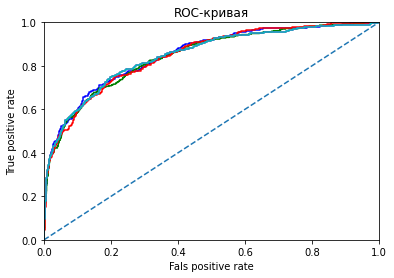

In [66]:
fpr_nd, tpr_nd, thresholds_nd = roc_curve(target_test, probabilities_one_test_nd)
fpr_up, tpr_up, thresholds_up = roc_curve(target_test, probabilities_one_test_up)
fpr_dw, tpr_dw, thresholds_dw = roc_curve(target_test, probabilities_one_test_dw)
fpr, tpr, thresholds = roc_curve(target_test, probabilities_one_test_adj_thr)
fpr_rf, tpr_rf, thresholds_rf = roc_curve(target_test, probabilities_one_test_rf)

plt.figure()

plt.plot([0, 1], [0, 1], linestyle = '--')
plt.plot(fpr_nd, tpr_nd, color = 'b')
plt.plot(fpr_up, tpr_up, color = 'g')
plt.plot(fpr_dw, tpr_dw, color = 'r')
plt.plot(fpr_rf, tpr_rf, color = 'm')
plt.plot(fpr, tpr, color = 'c')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('Fals positive rate')
plt.ylabel('True positive rate')
plt.title('ROC-кривая')

plt.show()

На тестовой выборке модель обученная с применением метода взвешивания классов показала следующие параметры f1 - 0.6 auc-roc - 0.852, модель обученная  с применением метода увеличения выборки показала f1-0.59, auc-roc - 0.845, метод уменьшения выборки показал f1 - 0.57 (меньше требуемого критерия), auc-roc - 0.848. Метод изменения классификационного порога показал следующие метрики f1 - 0,59, roc_auc = 0.848. Для используемых данных больше всего подходит метод борьбы с дисбалансом -  взвешивание классов.

Выводы по проекту.<br>
1.Для анализа получены данные об ушедших клиентах коммерческого банка для построения модели предсказаний расторжения договора с банком. Заполнены пропуски в столбце tenure, для дальнейшего анализа из данных убраны столбцы с фамилией, номером по прорядку, идентификационном номере клиента, создали мнимые признаки для пола и мест жительства клиента.<br>
2.Данные имеют дисбаланс отрицательного класса. При обучении моделей на таких данных (даже при автоматическом подборе гиперпараметров) метрика f1 не достигает целевого значения 0,59. Для дальнейшей борьбы с дибалансом отобрана модель случайного леса<br>
3.Борьба с дисбалансом осуществлена методами взвешивания данных, увеличения выборки, уменьшения выборки, изменения порога классификации. На тестовых данных лучший результат показал метод взвешивания данных  f1 - 0,6 auc-roc - 0.852.